In [1]:
from keras.applications import VGG16

In [5]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 16s 0us/step


### model存放路径 C:\Users\ryan\.keras\models\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 不使用数据增强的快速特征提取

In [7]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [8]:
base_dir = './cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

### 使用预训练的卷积基提取特征

In [10]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                           target_size=(150,150),
                                           batch_size=batch_size,
                                           class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size: (i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break
        return features, labels

In [11]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

### 定义密集连接分类器

In [14]:
from keras import layers
from keras import models
from keras import optimizers

In [15]:
model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-4),
             metrics=["acc"])

history = model.fit(train_features,train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 4s 35ms/step - loss: 0.6711 - acc: 0.9970 - val_loss: 0.6750 - val_acc: 0.9900
Epoch 2/30
100/100 [==============================] - 3s 34ms/step - loss: 0.6134 - acc: 0.9975 - val_loss: 0.5926 - val_acc: 0.9900
Epoch 3/30
100/100 [==============================] - 3s 32ms/step - loss: 0.5317 - acc: 0.9975 - val_loss: 0.5049 - val_acc: 0.9900
Epoch 4/30
100/100 [==============================] - 3s 32ms/step - loss: 0.4425 - acc: 0.9985 - val_loss: 0.4526 - val_acc: 0.9900
Epoch 5/30
100/100 [==============================] - 3s 32ms/step - loss: 0.3472 - acc: 0.9995 - val_loss: 0.3463 - val_acc: 0.9900
Epoch 6/30
100/100 [==============================] - 4s 36ms/step - loss: 0.2609 - acc: 0.9995 - val_loss: 0.2523 - val_acc: 0.9910
Epoch 7/30
100/100 [==============================] - 3s 34ms/step - loss: 0.1879 - acc: 1.0000 - val_loss: 0.1943 - val_acc: 0.9910
Epoch 8/30
100/100 [==============================] - 3s 34ms/step - 

In [16]:
import matplotlib.pylab as plt

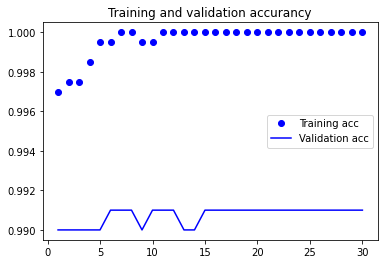

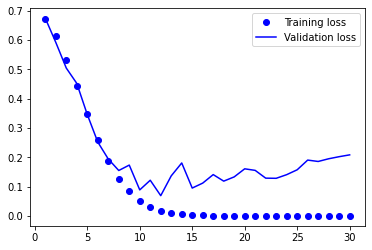

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accurancy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()

### 使用数据增强的特征提取

In [18]:
model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

In [19]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [20]:
print('This is the number of trainabke weights before freezing the conv base:', len(model1.trainable_weights))

This is the number of trainabke weights before freezing the conv base: 30


### 训练之前一定要冻结卷积基

In [21]:
conv_base.trainable = False

In [22]:
print('This is the number of trainabke weights after freezing the conv base:', len(model1.trainable_weights))

This is the number of trainabke weights after freezing the conv base: 4


In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [25]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

##### 训练太慢，需要使用GPU，中途停止了

In [29]:
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150,150),
                    batch_size=20,
                    class_mode='binary') 
validation_generator = test_datagen.flow_from_directory(
                    validation_dir,
                    target_size=(150,150),
                    batch_size=20,
                    class_mode='binary') 
model1.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=["acc"])
history = model1.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 1073s 11s/step - loss: 0.3271 - acc: 0.8580 - val_loss: 0.2627 - val_acc: 0.8910
Epoch 2/30
100/100 [==============================] - 1082s 11s/step - loss: 0.3400 - acc: 0.8500 - val_loss: 0.2463 - val_acc: 0.8960
Epoch 3/30
100/100 [==============================] - 1095s 11s/step - loss: 0.3140 - acc: 0.8595 - val_loss: 0.2440 - val_acc: 0.9010
Epoch 4/30
100/100 [==============================] - 1064s 11s/step - loss: 0.3177 - acc: 0.8615 - val_loss: 0.2417 - val_acc: 0.9020
Epoch 5/30
100/100 [==============================] - 1073s 11s/step - loss: 0.3237 - acc: 0.8585 - val_loss: 0.2430 - val_acc: 0.9060
Epoch 6/30
100/100 [==============================] - 1074s 11s/step - loss: 0.2990 - acc: 0.8725 - val_loss: 0.2459 - val_acc: 0.9020
Epoch 7/30
100/100 [==============================] - 1094s 11s/step - loss: 0.3016 - acc: 0.8630 - val_lo

KeyboardInterrupt: 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accurancy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()